In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style('white')


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle

import time

# Exploration of the data

In [2]:
# Read data
df = pd.read_csv("results.csv")
df.head()

# Remove na columns
print(df.shape)
df=df.dropna(axis=1)
print(df.shape)

# Prep data for clustering
# remove name column
df=df.drop(['name'], axis=1)
print(df.shape)

print(df.head())

(31984, 21)
(31984, 18)
(31984, 17)
     10k  division    25k gender  age  official bib  genderdiv     35k  \
0  17.37         8  47.67      M   47     85.25  W1          8    71.4   
1  32.58         1  82.43      F   33    138.95  F1          1  116.37   
2  16.62         1   45.8      M   41     80.60  W2          1   67.42   
3  32.57         3  82.43      F   24    140.58  F2          3  116.37   
4  17.12         2  46.37      M   40     81.23  W3          2   67.83   

   overall  pace    30k     5k   half    20k country     40k  
0        8  3.27  59.18   8.02  39.72  37.65     JPN   80.43  
1       21  5.30  99.33  16.22  69.47  65.83     KEN   132.1  
2        1  3.08  56.45   7.75  38.03   36.1     RSA    76.1  
3       27  5.37  99.33   16.2  69.47  65.83     ETH  132.95  
4        2  3.10  57.03   8.02   38.6  36.58     JPN   76.72  


In [3]:
df.head()

,10k,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,40k
0,17.37,8,47.67,M,47,85.25,W1,8,71.4,8,3.27,59.18,8.02,39.72,37.65,JPN,80.43
1,32.58,1,82.43,F,33,138.95,F1,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,132.1
2,16.62,1,45.8,M,41,80.60,W2,1,67.42,1,3.08,56.45,7.75,38.03,36.1,RSA,76.1
3,32.57,3,82.43,F,24,140.58,F2,3,116.37,27,5.37,99.33,16.2,69.47,65.83,ETH,132.95
4,17.12,2,46.37,M,40,81.23,W3,2,67.83,2,3.10,57.03,8.02,38.6,36.58,JPN,76.72


In [4]:
df.dtypes

10k           object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
35k           object
overall        int64
pace         float64
30k           object
5k            object
half          object
20k           object
country       object
40k           object
dtype: object

# Data cleaning
The bib number is a unique id, but it looks as if the bib number also indicates special cases, wheelchair participants and others, I will remove those.

In [5]:
# Delete all special case bibs
patternDel = "W"
filter = df['bib'].str.contains(patternDel)
print(df.shape)
dfnoW = df[~filter]
print(dfnoW.shape)


patternDel = "F"
filter = dfnoW['bib'].str.contains(patternDel)
dfnoWF = dfnoW[~filter]
print(dfnoWF.shape)
#Removed around 100 special racers

(31984, 17)
(31931, 17)
(31883, 17)


In [6]:
# Make gender binary
df_Cat= pd.get_dummies(dfnoWF['gender'])
cols= df_Cat.columns
df_Cat[cols] = df_Cat[cols].apply(pd.to_numeric, errors='coerce')
df_Cat.shape

(31883, 2)

In [7]:
# Select the numeric columns
df_Num = dfnoWF.drop(['country', 'gender','bib'], axis=1)
cols=df_Num.columns
df_Num[cols] = df_Num[cols].apply(pd.to_numeric, errors='coerce')

df_Num.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
7,30.48,5,76.95,29,129.83,5,107.47,5,4.97,92.52,15.17,64.85,61.62,122.80
9,30.48,20,77.68,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
11,30.52,2,76.97,28,128.80,2,107.47,2,4.92,92.52,15.18,64.87,61.63,121.95
20,30.50,3,76.95,29,128.83,3,107.47,3,4.92,92.52,15.18,64.90,61.63,122.22
22,30.50,17,76.97,27,137.20,17,109.12,17,5.23,92.52,15.17,64.88,61.62,128.18


I expect that the times intermediate times (5k, 10k, ...) will be very good indicators of the official end time, except for some people who don't finish. The correlation between these data is probably very high. So I will remove those, this should also remove a lot of outlayers.<br>
'Pace' is just calculated from the end time, this can be removed, too. 

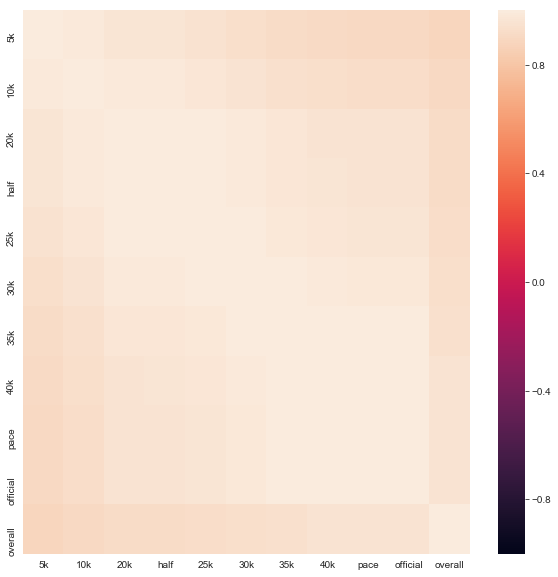

In [8]:
# Test correlation between endtime and interim times
cordata =df_Num[['5k','10k','20k','half','25k','30k','35k','40k','pace', 'official', 'overall']]
cordata.head()

CorrMa = cordata.corr(method='pearson')
plt.figure(figsize=(10,10))

sns.heatmap(CorrMa, vmin=-1, vmax=1)#[['INF_MORT_TREND']])



plt.show()


As expected, even the 5k time is a good indicator of the finish time. Therefore, I will drop them all.

In [9]:
df2 = df_Num.drop(['5k','10k','20k','half','25k','30k','35k','40k','pace', 'overall'], axis=1)
df2.head()

,division,age,official,genderdiv
7,5,29,129.83,5
9,20,31,137.83,20
11,2,28,128.80,2
20,3,29,128.83,3
22,17,27,137.20,17


In [10]:
# combine df_Cat and df_Num
df2cat=pd.concat([df2, df_Cat], axis=1)
print(df2cat.shape)
df2cat.head()

(31883, 6)


,division,age,official,genderdiv,F,M
7,5,29,129.83,5,0,1
9,20,31,137.83,20,0,1
11,2,28,128.80,2,0,1
20,3,29,128.83,3,0,1
22,17,27,137.20,17,0,1


In [11]:
df2cat.dtypes

division       int64
age            int64
official     float64
genderdiv      int64
F              uint8
M              uint8
dtype: object

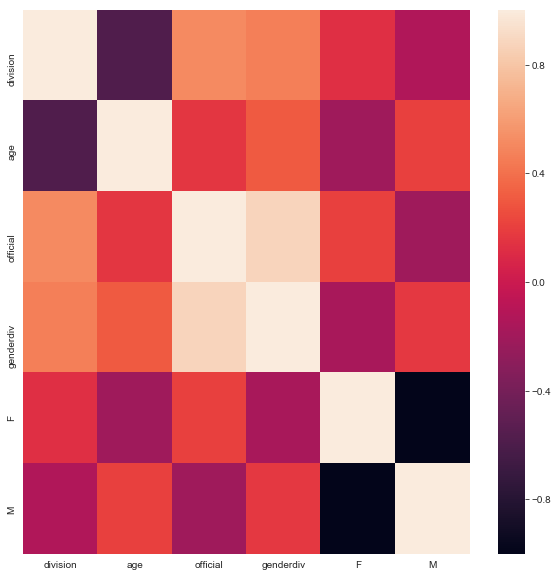

In [12]:
# Test correlation of the remaining variables
cordata =df2cat
cordata.head()

CorrMa = cordata.corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(CorrMa,vmin=-1, vmax=1)
plt.show()

I will further drop the gender devisions. I think this data is derived from the finish time and the gender.<br>
I will also convert the two binary colums male and female into one.

In [13]:
df2cat['Gender']=df2cat['F']
df3=df2cat.drop(['F','M','genderdiv'], axis=1)
df3.head()

,division,age,official,Gender
7,5,29,129.83,0
9,20,31,137.83,0
11,2,28,128.80,0
20,3,29,128.83,0
22,17,27,137.20,0


# Plotting the data
## finsh time ~ age

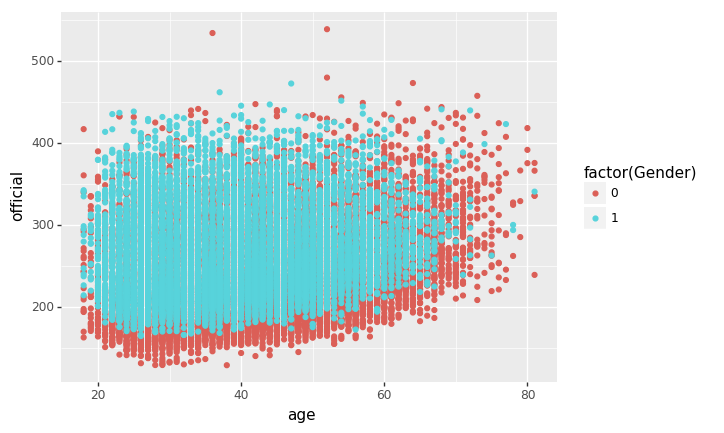

<ggplot: (-9223371921770087897)>

In [14]:
from plotnine import *

(ggplot(df3)
 + geom_point(aes(x='age', y='official', color='factor(Gender)'))
)

##  finish time ~ gender

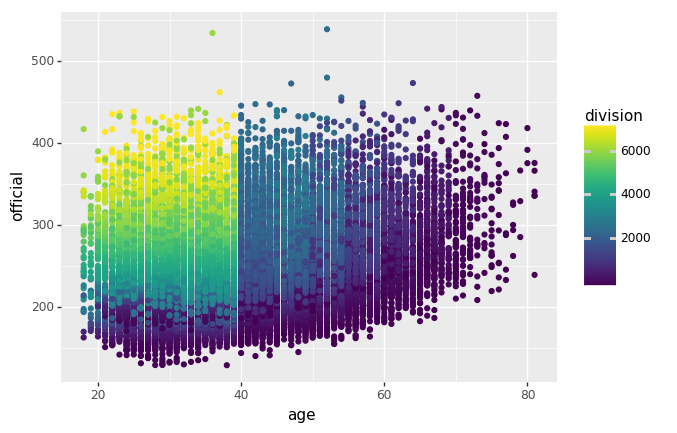

<ggplot: (115085127218)>

In [15]:
(ggplot(df3)
 + geom_point(aes(x='age', y='official', color='division'))
)

## finish time ~ division colored by gender

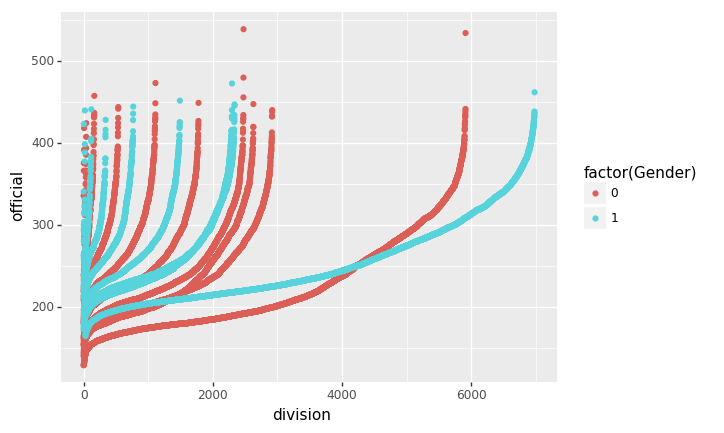

<ggplot: (115085014185)>

In [16]:
(ggplot(df3)
 + geom_point(aes(x='division', y='official', color='factor(Gender)'))
)

## finish time ~ division colored by age

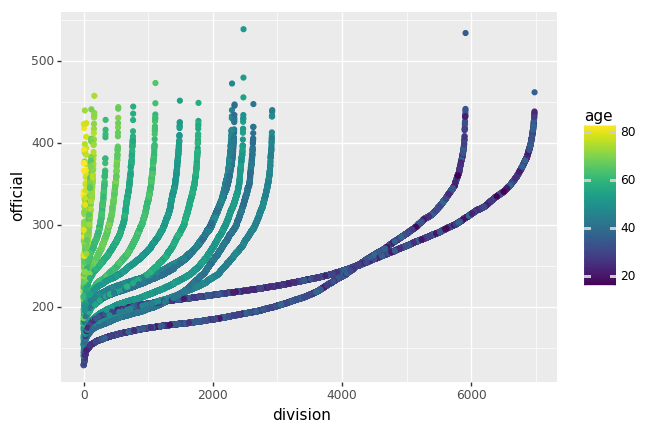

<ggplot: (-9223371921769701849)>

In [17]:
(ggplot(df3)
 + geom_point(aes(x='division', y='official', color='age'))
)

## finish time ~ division with ageCat

In [18]:
bin = [18,30,40,50,60,70,80,90,100]
#use pd.cut function can attribute the values into its specific bins
category = pd.cut(df3.age,bin)
category = category.to_frame()
category.columns = ['range']
#concatenate age and its bin
df3['ageCat'] = category
df3.head()


,division,age,official,Gender,ageCat
7,5,29,129.83,0,"(18, 30]"
9,20,31,137.83,0,"(30, 40]"
11,2,28,128.80,0,"(18, 30]"
20,3,29,128.83,0,"(18, 30]"
22,17,27,137.20,0,"(18, 30]"


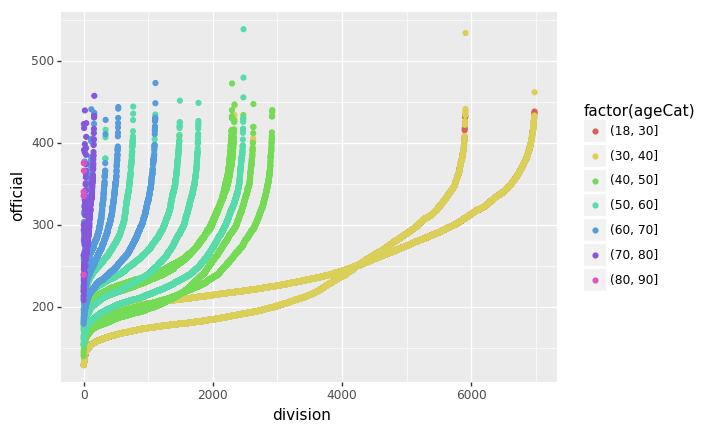

<ggplot: (-9223371921778064717)>

In [19]:
df3nona= df3.dropna()
(ggplot(df3nona)
 + geom_point(aes(x='division', y='official', color='factor(ageCat)'))
)

## finish time ~ logdiv with ageCat

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


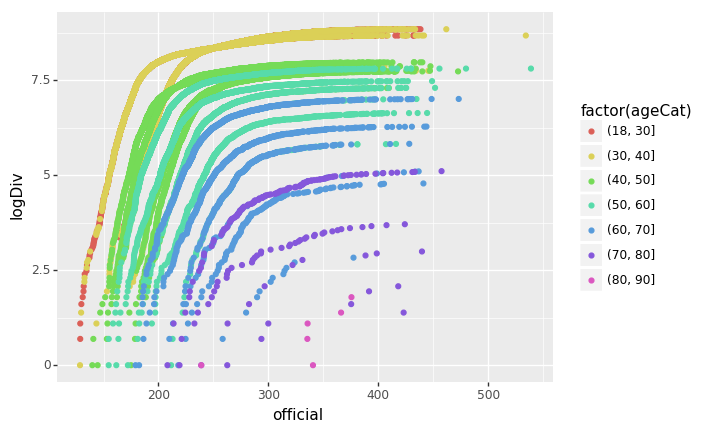

<ggplot: (115088571919)>

In [20]:
df3nona= df3.dropna()
df3nona['logDiv']=np.log(df3nona['division'])
(ggplot(df3nona)
 + geom_point(aes(x='official', y='logDiv', color='factor(ageCat)'))
)

## division ~ ageCat 

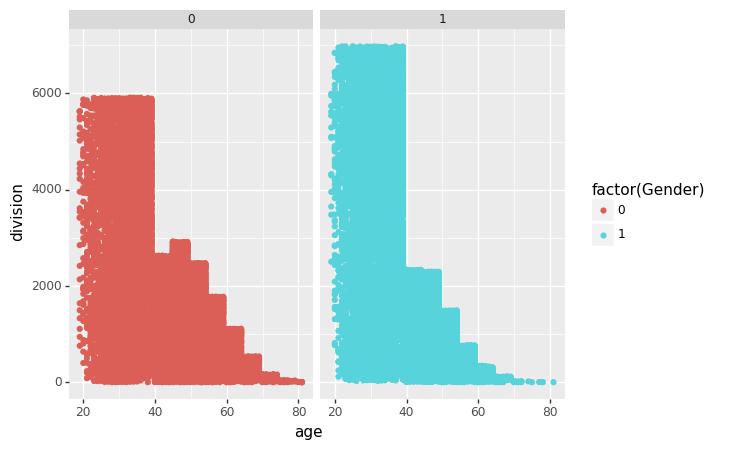

<ggplot: (115082122767)>

In [21]:
df3nona= df3.dropna()
(ggplot(df3nona)
 + geom_point(aes(x='age', y='division', color='factor(Gender)'))
 + facet_wrap('~Gender')
)

## finish time ~ age*div

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


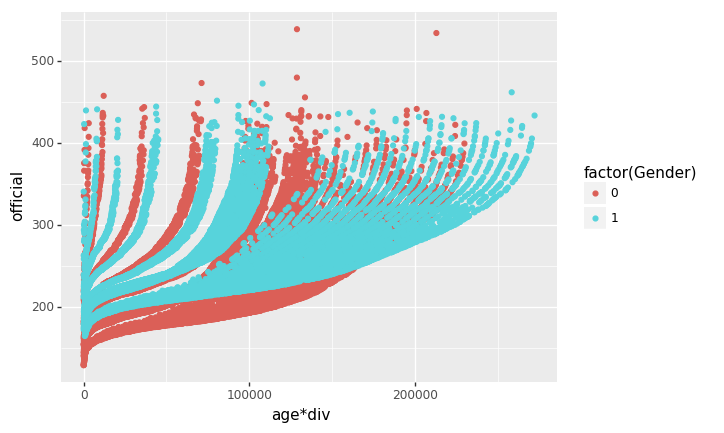

<ggplot: (115075278754)>

In [22]:
df3nona['age*div']= df3nona['age']*df3nona['division']

(ggplot(df3nona)
 + geom_point(aes(x='age*div', y='official', color='factor(Gender)'))
)

# Expectations
When considering age, gender and official end time, the remaining data has barely two clusters at all. However, when considering the devisions, there are clusters, but the clusters are anisotropic.<br>
## Expectation when using x=age and y=officials
K-means algorithm needs radially symmetrical clusters with similar variance, therefore I don't expect k-means to work well.
I will chose 2 as the number of clusters, to either identify the female runners, or maybe differentiate old and young runners as indicated by the divisions.
<br>
Mean-shift algorithm is more flexible, it does not need to know the number of expected clusters before hand. That seems promising. However, it might just generate one cluster. <br>
Affinity propagation and spectral clustering both using similarity matrices, however spectral clustering needs a number of expected clusters. Therefore, spectral clustering might work better.

## Expectation when using x=division and y=officials


# Functions

In [23]:
def RunMiniBatchKmeans(X_train, X_test, y_train, y_test,n_clusters):
    print()
    print('MiniBatch')
    minibatchkmeans = MiniBatchKMeans(
        init='random',
        n_clusters=n_clusters,
        batch_size=200)
    start_time=time.time()

    minibatchkmeans.fit(X_train)

    # Add the new predicted cluster memberships to the data frame.
    predict_mini = minibatchkmeans.predict(X_test)
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    
    # Plot the solution.
    plt.scatter(X_test[:, 0], X_test[:, 1], c=predict_mini)
    plt.show()
    
    df=pd.crosstab(y_test, predict_mini)
    
    print('Comparing Minibatch against the data:\n',pd.crosstab(predict_mini, y_test))
    return(predict_mini)

In [24]:
def RunSpectralClustering(X_train, X_test, y_train, y_test,n_clusters):
    print()
    print('Spectral clustering')
    start_time=time.time()
    
    # Declare and fit the model.
    sc = SpectralClustering(n_clusters=n_clusters)
    sc.fit(X_train)

    #Predicted clusters.
    predict=sc.fit_predict(X_test)
    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    #Graph results.
    plt.scatter(X_test[:, 0], X_test[:, 1], c=predict)
    plt.show()

    print('Comparing the assigned categories to the ones in the data:')
    print(pd.crosstab(y_test,predict))

In [25]:
def RunMeanShift(X_train, X_test, y_train, y_test):
    print()
    print('Meanshift')
    start_time=time.time()
    
    bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)
    
    print('bandwidth:', bandwidth)
    
    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    MS=ms.fit(X_train)
    
    predict_MeanShift=MS.predict(X_test)
    
    # Count number of clusters.
    n_clusters_ = len(np.unique(predict_MeanShift))

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print("Number of estimated clusters: {}".format(n_clusters_))

   
    # Plot the solution.
    plt.scatter(X_test[:, 0], X_test[:, 1], c=predict_MeanShift)
    plt.show()

    print('Comparing the assigned categories to the ones in the data:')
    print(pd.crosstab(y_test,predict_MeanShift))

In [26]:
def RunAffinityPropagation(X_train, X_test, y_train, y_test):
    print()
    print('Affinity Propagation')
    start_time=time.time()
    
    # Declare the model and fit it in one statement.
    # Note that you can provide arguments to the model, but we didn't.
    af = AffinityPropagation().fit(X_train)
    print('Done')

    labels= af.predict(X_test)
    # Pull the number of clusters and cluster assignments for each data point.
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(np.unique(labels))

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Estimated number of clusters: {}'.format(n_clusters_))

    print('Comparing the assigned categories to the ones in the data:')
    print(pd.crosstab(y_test,labels))
    
    plt.figure(1)
    plt.clf()

    # Cycle through each cluster and graph them with a center point for the
    # exemplar and lines from the exemplar to each data point in the cluster.
    colors = cycle('bgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        class_members = labels == k
        cluster_center = X_test[cluster_centers_indices[k]]
        plt.plot(X_test[class_members, 0], X_test[class_members, 1], col + '.')
        plt.plot(cluster_center[0],
                 cluster_center[1],
                 'o',
                 markerfacecolor=col,
                 markeredgecolor='k')
        for x in X_test[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.title('Estimated number of clusters: {}'.format(n_clusters_))
    plt.show()

# Can clustering predict the gender of a racer?
##  x=age, officials and y=gender

In [27]:
# Prepare data
df3nona=df3.dropna()

df4 = pd.DataFrame(normalize(df3nona[['division','age', 'official']]))
df4.columns = ['division','age', 'official']
#print(df4.head())
df61=df4[['age', 'official']] # select the 1st and 2nd column
df61['Gender']=df3nona['Gender']
df61_small = df61.sample(n=3000, random_state=1)# reduce the sample size

X1=df61_small.iloc[:,0:2].values
y1 =df61_small['Gender'].values

print(df61_small.head())

            age  official  Gender
6899   0.210997  0.943597     0.0
27266  0.021866  0.127649     1.0
4160   0.030703  0.162604     0.0
29879  0.032844  0.196055     0.0
17337  0.044922  0.203543     0.0


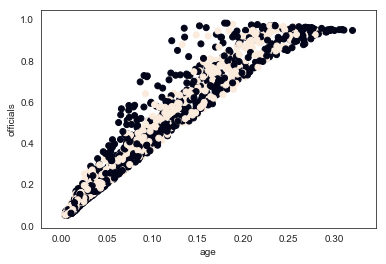

In [28]:
plt.scatter(X1[:, 0], X1[:, 1], c=y1)
plt.xlabel('age')
plt.ylabel('officials')

plt.show()

There are no clusters left after normalization. Let's what the clsutering algorithm think.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)


MiniBatch
Time taken: 0.013 seconds.


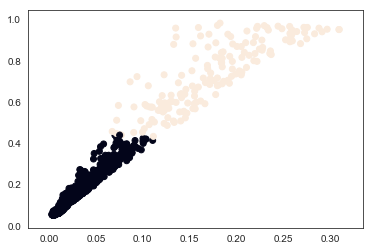

Comparing Minibatch against the data:
 col_0  0.0  1.0
row_0          
0      396  335
1       94   70

Spectral clustering
Time taken: 0.877 seconds.


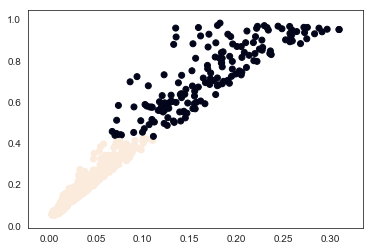

Comparing the assigned categories to the ones in the data:
col_0   0    1
row_0         
0.0    94  396
1.0    73  332


In [30]:
# given number of clusters
RunMiniBatchKmeans(X_train, X_test, y_train, y_test,2)
RunSpectralClustering(X_train, X_test, y_train, y_test,2)


Meanshift
bandwidth: 0.0971329436547608
Time taken: 0.128 seconds.
Number of estimated clusters: 3


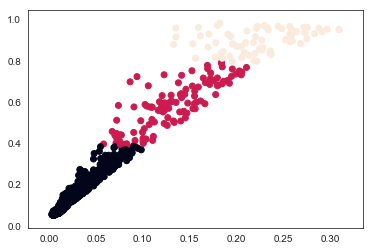

Comparing the assigned categories to the ones in the data:
col_0    0   1   2
row_0             
0.0    383  63  44
1.0    325  58  22

Affinity Propagation
Done
Time taken: 19.305 seconds.
Estimated number of clusters: 388
Comparing the assigned categories to the ones in the data:
col_0  1     3     5     6     8     13    18    20    21    23    ...   1055  \
row_0                                                              ...          
0.0       0    12     1     1     1     1     0     0     1     1  ...      2   
1.0       1    14     2     0     1     0     1     1     0     1  ...      1   

col_0  1059  1060  1063  1066  1067  1068  1069  1072  1073  
row_0                                                        
0.0       1     1     1     1     1     2     1     1     0  
1.0       0     0     0     0     0     2     0     1     2  

[2 rows x 388 columns]


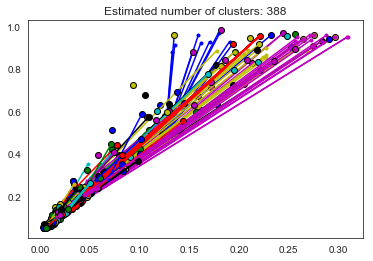

In [31]:
# Without explicit determination of cluster
RunMeanShift(X_train, X_test, y_train, y_test)
RunAffinityPropagation(X_train, X_test, y_train, y_test) #takes very long

## x=division, official y= gender

As the data as depictured in plot 3.4 clearly forms thin lines differentiating the runners by age, sex and end time, I will try in a second attempt to cluster this data. 

    division  age  official  Gender    ageCat
7          5   29    129.83       0  (18, 30]
9         20   31    137.83       0  (30, 40]
11         2   28    128.80       0  (18, 30]
20         3   29    128.83       0  (18, 30]
22        17   27    137.20       0  (18, 30]
(31851, 5)


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


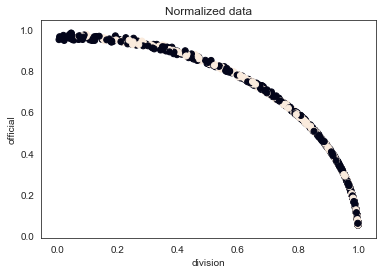

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


       division  official  age  Gender
7009         52    192.30   43       1
27389      1950    251.03   43       0
4268       1060    174.77   33       0
30008      1671    334.28   56       0
17449      1241    258.27   57       0


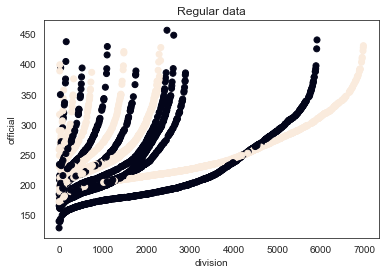

In [32]:
# Prepare data
df3nona=df3.dropna()
#
print(df3nona.head())
print(df3nona.shape)
df4 = pd.DataFrame(normalize(df3nona[['division','age', 'official']]))
df4.columns = ['division','age', 'official']

df62=df4[['division','official','age']] # select the 1st and 3rd column
df62['Gender']=df3nona['Gender']
df62_small = df62.sample(n=3000, random_state=1)# reduce the sample size

X2=df62_small.iloc[:,0:3].values
y2 =df62_small.iloc[:,3].values

plt.scatter(X2[:, 0], X2[:, 1], c=y2)
plt.xlabel('division')
plt.ylabel('official')
plt.title('Normalized data')
plt.show()

# When the data is normalized the structure is gone
# in order to keep the clusters, I will use non-normalized data
df62=df3nona[['division','official','age']] # select the 1st,2nd and 3rd column
df62['Gender']=df3nona['Gender']
df62_small = df62.sample(n=3000, random_state=1)
print(df62_small.head())

X2=df62_small.iloc[:,0:3].values
y2 =df62_small['Gender'].values

plt.scatter(X2[:, 0], X2[:, 1], c=y2)
plt.xlabel('division')
plt.ylabel('official')
plt.title('Regular data')
plt.show()

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=42)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

MiniBatch
Time taken: 0.066 seconds.


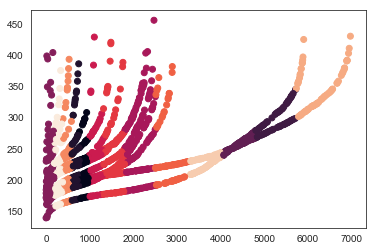

Comparing Minibatch against the data:
 col_0    0   1
row_0         
0       51  39
1       51  41
2       38  36
3       40  39
4       75  64
5      128  77
6       72  68
7      126  77
8       52  40
9       69  45
10      14  55
11      44  30
12      70  59

Spectral clustering


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


LinAlgError: 13-th leading minor of the array is not positive definite

In [33]:
# given number of clusters ~ 13

print(type(X2_test))
print(type(y2_test))

RunMiniBatchKmeans(X2_train, X2_test, y2_train, y2_test,13)
RunSpectralClustering(X2_train, X2_test, y2_train, y2_test,13) # gives a warning and runs forever

In [ ]:
# Without explicit determination of cluster
RunMeanShift(X2_train, X2_test, y2_train, y2_test)
RunAffinityPropagation(X2_train, X2_test, y2_train, y2_test) 

## Clustering- Results

### age, officials 
None of the algorithms is able to differentiate the gender when using age and finish time as data. Which is not surprising, as the data truely does not form any clusters. The clustering algorithms rather cluster in slow and old and young and fast racers. 


### division, officials, age
When using division, officials and age (not normalized) as features for the clustering there are thin lines that differentiate the genders by age group, as seen in plot 3.4. I tried to differentiate those clusters using k-means, meanshift, spectra clustering and affinity propagation. The lines/clusters/groups lay close together, except for the young groups. 

# Predicting the finish time by division

Using the normalized data to predict the finish time of a runner, using division and the age.

## Functions for prediction



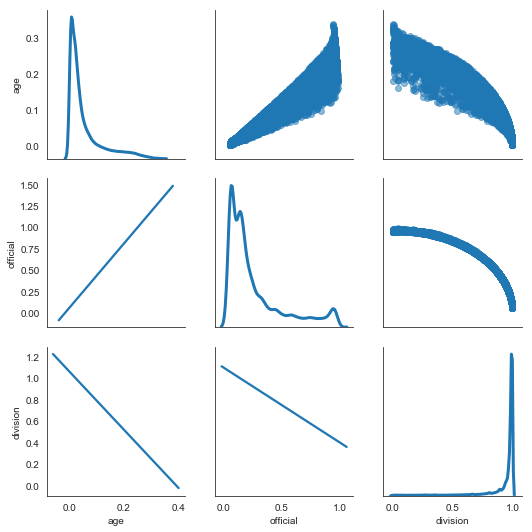

In [46]:
Xy=df4[['age','official', 'division']]

# Make a scatterplot matrix.
g = sns.PairGrid(Xy.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

### Linear Model


Coefficients: 
 [ 3.52055662 -0.09440816]

Intercept: 
 0.15240877324991878

R-squared:
0.9549320977076716


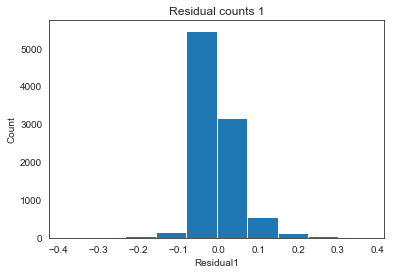

In [54]:
#Prepare data

from sklearn import linear_model

X = df4[['age','division']]
y = df4.official

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
 # Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_test, y_test))

    # Extract predicted values.
predicted = regr.predict(X_test).ravel()
actual = y_test.ravel()

# Calculate the error, also called the residual.
residual = actual - predicted

# Check for normal distribution of the error
plt.hist(residual)
plt.title('Residual counts 1')
plt.xlabel('Residual1')
plt.ylabel('Count')
plt.show()

In [55]:
from sklearn.model_selection import cross_val_score
def runLM(input_df, target, no_folds):
    start_time=time.time()
    
    linreg = linear_model.LinearRegression()   
    cvs = cross_val_score(linreg, input_df, target, cv=no_folds)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    # print(regr.feature_importances_)
    return(cvs)

In [56]:
runLM(X,y,5)

Time taken: 0.028 seconds.
Average accuracy RFC: 0.945
Standard deviation of accuracy: 0.022


array([0.93285436, 0.93576673, 0.96583728, 0.96956776, 0.9200984 ])

### Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
## Functions for prediction
def runRFR(input_df, target, no_folds):
    start_time=time.time()
    
    rand_forest_reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)   
    cvs = cross_val_score(rand_forest_reg, input_df, target, cv=no_folds)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    # print(regr.feature_importances_)
    return(cvs)

In [58]:
runRFR(X,y,5)

Time taken: 2.992 seconds.
Average accuracy RFC: 0.919
Standard deviation of accuracy: 0.058


array([0.95651863, 0.9335218 , 0.93418911, 0.95284442, 0.81783328])

Random forest badly overfitts
### KNN

In [59]:
from sklearn.neighbors import KNeighborsRegressor

def runKNN_regr(input_df, target,numNeigh, no_folds):
    start_time=time.time()
    knn_w = KNeighborsRegressor(n_neighbors=numNeigh, weights='distance')
    # cross validation
    cvs = cross_val_score(knn_w, input_df, target, cv=no_folds)   
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy KNN with weights: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [60]:
runKNN_regr(X,y,3,5)

Time taken: 0.277 seconds.
Average accuracy KNN with weights: 1.000
Standard deviation of accuracy: 0.000


array([0.99996358, 0.99998305, 0.9999911 , 0.99999613, 0.99999044])